# practicalMixGaussB

The goal of this part of the lab is to fit a mixture of gaussians model to some one-dimensional data. To do this, we will first generate some data from a known mixture of gaussians model and fit our own mixture of gaussians model to the generated data. The parameters from our estimated mixture of gaussians model should roughly match those of the original known model. 

You should use this template for your code and fill in the missing 
sections marked "TO DO."

PLEASE NOTE (again): You should NOT be using functions like multivariate_normal.pdf and normfit or any other numpy functions for fitting your distributions in this or further parts of this practical. Optionally, you can try comparing your results to those produced by those functions, but our goal here is to learn what is happening!

In [1]:
import os 
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as spio
from scipy.stats import norm 
import time

%matplotlib inline

## Construct Ground Truth Mixture of Gaussians Model and Plot Some Points

Define some true parameters for our grounf truth mixture of $k$ Gaussians model. We will represent the mixtures of Gaussians as a python dictionary. Not that we are working in one dimension, but if we were to require $d$ dimenisions, the mean field would be a $d \times k$ matrix and the cov field would be a $d \times d \times k$ matrix. 

In [2]:
mixGaussTrue = dict()
mixGaussTrue['k'] = 2 # number of gaussians
mixGaussTrue['d'] = 1 # dimension of the data
mixGaussTrue['weight'] = np.array([0.3, 0.7]) # weight assigned to each gaussian (lambda_k)
mixGaussTrue['mean'] = np.array([[-1,1.5]]) # the mean for each gaussian 
mixGaussTrue['cov'] = np.reshape([0.5, 0.25], newshape=(1,1,2)) # the covariance for each gaussian

**getGaussProb**, **sampleFromDiscrete**, and **drawEMData1d** are helper functions. 

In [3]:
# subroutine to return gaussian probabilities - just a normal univariate gaussian distribution with mean and variance
def getGaussProb(x,mean,var):   
    """
    Returns the likelihood that each data point in x belongs to the Gaussian described by mean and 
    var.
    
    Keyword arguments:
    x -- 1 by n vector of data points. n is the number of data points.
    mean -- scalar containing the mean parameter of the Gaussian distribution.
    var -- scalar containing the variance parameter of the Gaussian distribution.
    
    Returns: 
    prob -- 1 by n vector containing the likelihood that each data point in data belongs to the Gaussian 
    distribution defined by mean and var.
    """
    mean = np.squeeze(mean)                                        
    var = np.squeeze(var)                                          
    prob = np.exp(-0.5*((x-mean)**2)/(var))                        
    prob = prob/ np.sqrt(2*np.pi*var)                              
    return prob                                                    

In [4]:
# Let's play with this function and see if it can return values for multiple means and variables (i.e. if we have a mixture of gaussians)

mixGaussTrue['weight'] * getGaussProb(4, mixGaussTrue['mean'], mixGaussTrue['cov']) / mixGaussTrue['weight']

# Damn, okay, so you can update your code and get rid of for loops! Because you can input the multiple means and covariances here and this
# function will return an array with the probabilities of data x in each cluster!

array([7.83543327e-12, 2.97343903e-06])

In [5]:
def sampleFromDiscrete(probDist): 
    """
    Draws a random sample from a discrete probability distribution using a rejection sampling method.  
    
    Keyword arguments:
    probDist -- discrete probability ditrubtion to sample from.
    
    Returns: 
    r -- sampled point.
    """

    nIndex = len(probDist)                                                                 
    while True:                                                                            
        #choose random index                                                               
        r=int(np.floor(np.random.uniform()*nIndex))                                        
        #choose random height                                                              
        randHeight = np.random.uniform()                                                   
        #if height is less than probability value at this point in the                     
        #histogram then select                                                            
        if randHeight<probDist[r]:                                                         
            break                                                                          
    return r                                                                               

In [19]:
h = sampleFromDiscrete(mixGaussTrue['weight']) 
# we got 2 weights, so we have two options in the discrete distribution, either 0 or 1. This can represent the hidden variables.
# ie. which gaussian we will be using in the mixture of gaussians.

mixGaussTrue['cov'][:,:,h]
mixGaussTrue['mean'][:,h]
# Note that because we are in 1-d, the cov part only has values, not matrices, and so each value in the vector corresponds to
# the variance of each of the gaussians that take part in the mixture of gaussians.

# if h = 0, we use the parameters of the 1st gaussian, if h = 1 we use the parameters of the 2nd one, and so on.

array([1.5])

In [7]:
def drawEMData1d(data, mixGauss):
    """
    Draw the data, data, in histogram form and plot the mixtures of Gaussian model, mixGauss, on top of it.
    
    Keyword arguments:
    data -- 1 by n vector of data points.
    mixGauss -- dict with mixture of gaussian information.

    """
    # delete previous plot if it exists                                                                   
    # hold off;                                                                                           
    # bin the data to make a histogram                                                                    
                                                                                                          
    binWidth = 0.1;                                                                                       
    binMin = -4.0;                                                                                        
    binMax = 4.0;                                                                                         
    nSteps = int(np.ceil((binMax - binMin) / binWidth))                                                   
                                                                                                          
    nDims, nData = data.shape                                                                             
                                                                                                          
    xHist = np.linspace(binMin, binMax, nSteps, endpoint=True)                                            
    xHistExt = np.append(xHist, np.inf)                                                                   
    yHist, _ = np.histogram(data, xHistExt)                                     
                                                                                                          
    yHist = yHist / (nData * binWidth)                                                                    
    plt.cla()                                                                                     
    plt.bar(xHist, yHist, binWidth, edgecolor='b')                                                        
                                                                                                          
    # calculate Gaussian data                                                                             
    nGauss = mixGauss['k']                                                                                
    gaussEnvEst = np.zeros(xHist.shape)                                                                   
    for cGauss in range(nGauss):                                                                          
        # calculate weighted Gaussian values                                                              
        gaussProb = mixGauss['weight'][cGauss] * getGaussProb(xHist, mixGauss['mean'][:,cGauss],          
                                                              mixGauss['cov'][:, :, cGauss])              
        plt.plot(xHist, gaussProb, 'm-')  # weighted components of MoG                                    
        # add to form envelope                                                                            
        gaussEnvEst = gaussEnvEst + gaussProb                                                             
                                                                                                          
    plt.plot(xHist, gaussEnvEst, 'g-')  # final mixture of Gaussians                                      
                                                                                                          
    # tidy up plot                                                                                        
    plt.xlabel('Data Value')                                                                              
    plt.ylabel('Probability Density')                                                                     
    # set(gca,'Box','Off');                                                                               
    # set(gcf,'Color',[1 1 1]);                                                                           
    plt.xlim((binMin, binMax))                                                                            
    plt.ylim((0, max(yHist) * 1.5))                                                                       
                                                                                                          
    return                                                                                                
    

**TODO D HERE:**

Complete the TO DO in this function before moving on. 



In [20]:
def mixGaussGen1d(mixGauss, nData):  
    """
    Generates data from a one-dimensional mixture of Gaussians model. 
    
    Keyword arguments:
    mixGauss -- dict containing the mixture of gaussians arguments.
    nData -- number of data points to generate.
    
    Returns: 
    data -- 1 by nData, generated data points. 
    """
    
    # create space for output data                                                                               
    data = np.zeros(shape=(1, nData))                                                                            
    # for each data point                                                                                        
    for cData in range(nData):                                                                                   
        # randomly choose Gaussian according to probability distributions                                        
        h = sampleFromDiscrete(mixGauss['weight'])        # this shows us from which of the available gaussians we will sample                                                       
        # draw a sample from the appropriate Gaussian distribution                                               
        
        # TO DO (d)- now we just need to randomly draw a data point from the gaussian distribution specified by h
        data[:, cData] = np.random.normal(mixGauss['mean'][:,h], mixGauss['cov'][:,:,h])
                                                                        
    return data                                                                                                  

With all the helper functions complete, we can now generate and plot some points from our model. The blue bars are the histogram of the generated points. The green curve is what the complete mixture of gaussians model looks like. The pink curves are the component gaussians. 

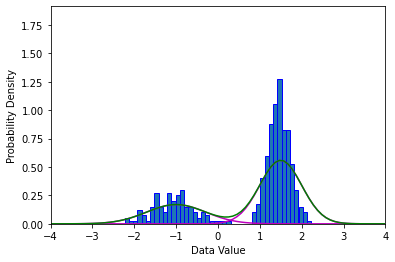

In [21]:
# define number of samples to generate
nData = 400

#generate data from the mixture of Gaussians
#make sure you've filled out the todo above! 
data = mixGaussGen1d(mixGaussTrue,nData)

#plot! 
fig,ax = plt.subplots(1,1)
drawEMData1d(data,mixGaussTrue)

This is just a histogram with the data that we have extracted from the True Mixture of Gaussians distribution with two clusters.
Each pink line corresponds to each component of the mixture of gaussians, and the green line is the weighted combination of the components, resulting in the final bi-modal distribution.

## Estimate MoG using the E-M Algorithm
Here we want to use the E-M algorithm to fit a MoG model to our data points. 

**TODO E HERE:** 

Fill out the missing parts below. 

In [22]:
def getMixGaussBound(data, mixGaussEst, responsibilities):                                                  
    """
    Calculate the bound on the log likelihood for the whole data set under a mixture of Gaussians model.  
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    mixGaussEst -- dict containing the mixture of gaussians parameters.
    responsibilities -- k by n vector containing the responsibility of this data point for each Gaussian. 
                        so each column sums to 1, and each value corresponds to the responsibility of ...
                        ... that m data point to cluster k.
    
    Returns: 
    bound -- scalar containing the bound on the log likelihood.
    
    """
    # find total number of data items                                                                       
    nDims, nData = data.shape                                                                               
                                                                                                            
    # initialize bound                                                                                      
    bound = 0                                                                                               
    
        
    # run through each data item                                                                            
    for cData in range(nData):                                                                              
        # extract this data                                                                                 
        thisData = data[:, cData]                                                                           
        # extract this q(h)                                                                                 
        thisQ = responsibilities[:, cData]                                                                  
                                                                                                            
        # TO DO (e) - calculate contribution to bound of this datapoint.
        # Note that because we are in 1-d, we can use the getGaussProb function defined before.
        # No need to worry about thisData being multi-dimensional (column or row vector). It is just a 1-dimensional array.   

        boundValue = 0

        '''
        for k in range(mixGaussEst['k']): 
            lam = mixGaussEst['weight'][k]
            mu = mixGaussEst['mean'][0][k]
            sigma = mixGaussEst['cov'][0][0][k]
            rik = thisQ[k]
            boundValue += rik * np.log(lam * getGaussProb(thisData, mu, sigma) / rik)
        
        '''
        lam = mixGaussEst['weight']
        mu = mixGaussEst['mean']
        sigma = mixGaussEst['cov']
        boundValue = np.sum(thisQ * np.log(lam * getGaussProb(thisData, mu, sigma) / thisQ))
            
        # add to total log like                                                                             
        bound = bound + boundValue                                                                          
                                                                                                            
    return bound.item() # np.asscalar(np.array(bound)) -- this modification was suggested when I ran the code                                                                          

**TODO F HERE:** 

Fill out the missing parts below. 

The log likelihood is taken since the raw likelihood value could be too small for our machine's percision. 

In [23]:
def getMixGaussLogLike(data, mixGaussEst):
    """
    Calculate the log likelihood for the whole dataset under a mixture of Gaussians model.
    
    Keyword arguments:
    data -- d by n matrix containing data points.
    mixGaussEst -- dict containing the mixture of gaussians parameters.

    Returns: 
    logLike -- scalar containing the log likelihood.
    
    """
    data = np.atleast_2d(data)                                                                         
    # find total number of data items                                                                  
    nDims, nData = data.shape                                                                          
    
    # initialize log likelihoods                                                                       
    logLike = 0;                                                                                       
                                                                                                       
    # run through each data item                                                                       
    for cData in range(nData):                                                                         
        thisData = data[:, cData]    
        
        # TO DO (f) - calculate likelihood of this data point under mixture of                         
        # Gaussians model.
        like = 0
        
        '''
        for k in range(mixGaussEst['k']):
            lam = mixGaussEst['weight'][k]
            mu = mixGaussEst['mean'][0][k]
            sigma = mixGaussEst['cov'][0][0][k]                                                               
            like += lam * getGaussProb(thisData, mu, sigma)
        '''
        
        lam = mixGaussEst['weight']
        mu = mixGaussEst['mean']
        sigma = mixGaussEst['cov']
        like = np.sum(lam * getGaussProb(thisData, mu, sigma))                                                                                             
        # add to total log like                                                                        
        logLike = logLike + np.log(like)                                                               
                                                                                                       
    return  logLike.item() # np.asscalar(np.array(logLike)) -- this modification was suggested when I ran the code                                                                       
                                                                                                       

**TODO G HERE:** 

Fill out the missing parts below. 

In [24]:
def fitMixGauss1d(data, k):   
    """
    Estimate a k MoG model that would fit the data. Incremently plots the outcome.
               
    
    Keyword arguments:
    data -- d by n matrix containing data points. Note that in this part of the tutorial d = 1.
    k -- scalar representing the number of gaussians to use in the MoG model.
    
    Returns: 
    mixGaussEst -- dict containing the estimated MoG parameters.
    
    """
    #     MAIN E-M ROUTINE  
    #     In the E-M algorithm, we calculate a complete posterior distribution over                                  
    #     the (nData) hidden variables in the E-Step.  
    #     In the M-Step, we update the parameters of the Gaussians (mean, cov, w).   
    
    nDims, nData = data.shape                                                                                        
                                                                                                                     
                                                                                                      
    responsibilities = np.zeros(shape=(k, nData))                                                                    
                                                                                                                     
    # we will initialize the values to random values                                                                 
    mixGaussEst = dict()                                                                                             
    mixGaussEst['d'] = 1                                                                                             
    mixGaussEst['k'] = k                                                                                             
    mixGaussEst['weight'] = (1 / k) * np.ones(shape=(k))                                                             
    mixGaussEst['mean'] = 2 * np.random.randn(1, k)                                                                  
    mixGaussEst['cov'] = 0.1 + 1.5*np.random.uniform(size=(1,1,2))                                                   
                                                                                                                     
    # calculate current likelihood                                                                                   
    # TO DO (g) starts here- fill in this routine                                                                                   
    logLike = getMixGaussLogLike(data, mixGaussEst)                                                                  
    print('Log Likelihood Iter 0 : {:4.3f}\n'.format(logLike))                                                       
                                                                                                                     
    nIter = 20;                                                                                                      
                                                                                                                     
    logLikeVec = np.zeros(shape=(2 * nIter))                                                                         
    boundVec = np.zeros(shape=(2 * nIter)) 
    
    fig,ax = plt.subplots(1,1)
                                                                                                                     
    for cIter in range(nIter):                                                                                       
                                                                                                                     
        # ===================== =====================                                                                
        # Expectation step                                                                                           
        # ===================== =====================                                                                
        curCov = mixGaussEst['cov']                                                                                  
        curWeight = mixGaussEst['weight']                                                                            
        curMean = mixGaussEst['mean']                                                                                
        for cData in range(nData):           
            # TO DO: fill in column of 'hidden' - caculate posterior probability that                                
            # this data point came from each of the Gaussians                                                        
            thisData = data[:, cData]
            numerator = curWeight * getGaussProb(thisData, curMean, curCov)                                                                                          
            responsibilities[:, cData] = numerator / np.sum(numerator)


        # calculate the log likelihood                                                                               
        logLike = getMixGaussLogLike(data, mixGaussEst)                                                              
        print('Log Likelihood After E-Step Iter {} : {:4.3f}\n'.format(cIter, logLike))                              
                                                                                                                     
        # calculate the bound                                                                                        
        # TO DO - Fill in this routine                                                                               
        bound = getMixGaussBound(data, mixGaussEst, responsibilities)                                                
        print('Bound After E-Step Iter {} : {:4.3f}\n'.format(cIter, bound))     
        
        logLikeVec[2 * cIter] = logLike                                                                              
        boundVec[2 * cIter] = bound                                                                                  
        # ===================== =====================                                                                
        # Maximization Step                                                                                          
        # ===================== =====================                                                                
        # for each constituent Gaussian                                                                              
        for cGauss in range(k):                                                                                      
            # TO DO:  Update weighting parameters mixGauss.weight based on the total                                 
            # posterior probability associated with each Gaussian. Replace this:
            # But first of all, it's useful to calculate the total responsibility allocated to each cluser (mc)
            # i.e. we sum the responsibility values along the cluster dimension (along the rows in this case)
            # --> it's just summing the responsibility of all data points for each cluster (sum all cols for each row).

            mc = np.sum(responsibilities[cGauss,:])

            mixGaussEst['weight'][cGauss] = mc / nData
            
                                                                                                                 
            # TO DO:  Update mean parameters mixGauss.mean by weighted average                                       
            # where weights are given by posterior probability associated with                                       
            # Gaussian.  Replace this:                                    
            mixGaussEst['mean'][:,cGauss] = (1/mc) * np.sum(responsibilities[cGauss,:] * data)
            
            
            # TO DO:  Update covarance parameter based on weighted average of                                        
            # square distance from update mean, where weights are given by                                           
            # posterior probability associated with Gaussian                                                         
            mixGaussEst['cov'][:,:,cGauss] = (1/mc) * np.sum(responsibilities[cGauss,:] * (data - mixGaussEst['mean'][:,cGauss])**2) 
            # Note that we can do **2 here and not worry about dimensions because we are in 1-d.
            
                                                                                                                     
        # draw the new solution  
        drawEMData1d(data, mixGaussEst)
        time.sleep(0.7)
        fig.canvas.draw()
                                                                                                                     
        # calculate the log likelihood                                                                               
        logLike = getMixGaussLogLike(data, mixGaussEst)                                                              
        print('Log Likelihood After M-Step Iter {} : {:4.3f}\n'.format(cIter, logLike))                              
                                                                                                                     
        # calculate the bound                                                                                        
        bound = getMixGaussBound(data, mixGaussEst, responsibilities)                                                
        print('Bound After M-Step Iter {} : {:4.3f}\n'.format(cIter, bound)) 
                                                                                                                  
        logLikeVec[2 * cIter + 1] = logLike                                                                          
        boundVec[2 * cIter + 1] = bound                                                                              
                                                                                                                     
    plt.figure()                                                                                                     
    plt.plot(logLikeVec, 'g',label='log likelihood')                                                                                        
    plt.plot(boundVec, 'r',label='lower bound')  
    plt.legend()
                                                                                                                     
    return mixGaussEst                                                                                               

### Time to put it all together!

Make sure you've filled all the TO DOs above! 

Log Likelihood Iter 0 : -1260.077

Log Likelihood After E-Step Iter 0 : -1260.077

Bound After E-Step Iter 0 : -1260.077

Log Likelihood After M-Step Iter 0 : -616.074

Bound After M-Step Iter 0 : -635.402

Log Likelihood After E-Step Iter 1 : -616.074

Bound After E-Step Iter 1 : -616.074

Log Likelihood After M-Step Iter 1 : -558.833

Bound After M-Step Iter 1 : -592.334

Log Likelihood After E-Step Iter 2 : -558.833

Bound After E-Step Iter 2 : -558.833

Log Likelihood After M-Step Iter 2 : -494.392

Bound After M-Step Iter 2 : -524.995

Log Likelihood After E-Step Iter 3 : -494.392

Bound After E-Step Iter 3 : -494.392

Log Likelihood After M-Step Iter 3 : -454.157

Bound After M-Step Iter 3 : -471.038

Log Likelihood After E-Step Iter 4 : -454.157

Bound After E-Step Iter 4 : -454.157

Log Likelihood After M-Step Iter 4 : -430.726

Bound After M-Step Iter 4 : -441.116

Log Likelihood After E-Step Iter 5 : -430.726

Bound After E-Step Iter 5 : -430.726

Log Likelihood After M-Step 

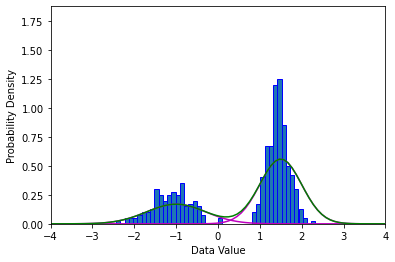

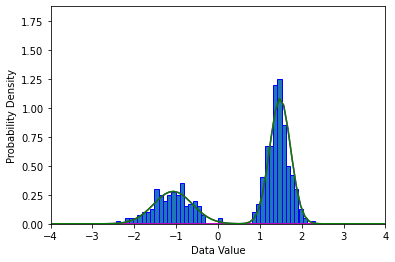

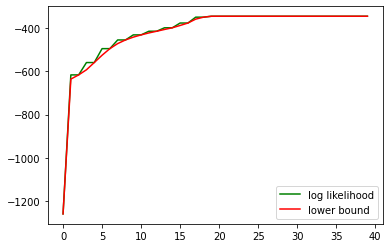

In [25]:
#generate data from the ground truth mixture of Gaussians we've defined way above. 
#make sure you've completed this routine above.
data = mixGaussGen1d(mixGaussTrue,nData)

#draw data, ground truth mixture of Gaussians.
drawEMData1d(data,mixGaussTrue)

#define number of components to estimate
nGaussEst = 2

#fit mixture of Gaussians (Pretend someone handed you some data. Now what?)
#Make sure you've completed this routine above.
mixGaussEst = fitMixGauss1d(data,nGaussEst)
#plt.show()

In this last set of plots we can observe how we have fitted the data from the true mixture of gaussians with an estimated mixture of gaussians using the E-M algorithm.  The resulting estimated distribution fits well the data, proving that the EM has converged. The weights of the gaussians and their respective means are almost the same as the ones in the true distribution. However, the variances are way smaller than in the true gaussian, fitting the data more tightly, which can result in overfitting (bias/variance tradeoff). To avoid this we could introduce a validation set.

The final plot shows the E and M steps in every iteration. In the maximisation step, the model parameters are updated, and the log likelihood is  higher than the lower bound. Then in the expectation step, every data point is re-associated to each of the clusters (re-calculation of responsibilities), and so the log likelihood does not update, but the lower bound, dependent on the responsibilities, catches up with the log likelihood.

We can also observe how the algorithm converges very quickly in the first iterations. Then the convergence slows down until reaching a plateau, which can be considered to be our solution. In this case, we reach a solution after 20 iterations. The remaining iterations are not really necessary, so we could dispense with them in order to accelerate our code.

In [26]:
# Check results

print(mixGaussEst)

print(mixGaussTrue)



{'d': 1, 'k': 2, 'weight': array([0.32500501, 0.67499499]), 'mean': array([[-1.07307483,  1.48526298]]), 'cov': array([[[0.21531019, 0.06188007]]])}
{'k': 2, 'd': 1, 'weight': array([0.3, 0.7]), 'mean': array([[-1. ,  1.5]]), 'cov': array([[[0.5 , 0.25]]])}
